In [1]:
import os
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
os.environ['OMP_NUM_THREADS'] = '4'

# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']= 'platform'
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm
from functools import partial
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import blackjax
from flax.training import train_state
import optax
import jaxopt

import sklearn
import sklearn.datasets

import matplotlib.pyplot as plt
from matplotlib import cm

from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "png")
plt.rcParams["savefig.dpi"] = 75
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = 6, 4
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["font.size"] = 16
plt.rcParams["lines.linewidth"] = 2.0
plt.rcParams["lines.markersize"] = 8
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.linewidth"] = 1.0
plt.rcParams["legend.facecolor"] = "white"
# plt.rcParams['grid.color'] = "grey"
plt.rcParams["text.usetex"] = True
# plt.rcParams['font.family'] = "normal"
# plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams[
    "text.latex.preamble"
] = "\\usepackage{subdepth} \\usepackage{amsfonts} \\usepackage{type1cm}"


/tmp/ipykernel_541457/2096830287.py:25: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("pdf", "png")


In [12]:
import torch
import sklearn

seed = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### LOAD DATA
def _one_hot(x, k):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k))

_x_train, _y_train = sklearn.datasets.make_moons(
    n_samples=200, shuffle=True, noise=0.2, random_state=seed
)

h = 0.25
test_lim = 3
x_min, x_max = -5, 5
y_min, y_max = -5, 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
_x_test = np.vstack((xx.reshape(-1), yy.reshape(-1))).T

h = 0.25
test_lim = 7
x_wide_min, x_wide_max = (
    _x_train[:, 0].min() - test_lim,
    _x_train[:, 0].max() + test_lim,
)
y_wide_min, y_wide_max = (
    _x_train[:, 1].min() - test_lim,
    _x_train[:, 1].max() + test_lim,
)
xx_wide, yy_wide = np.meshgrid(
    np.arange(x_wide_min, x_wide_max, h), np.arange(y_wide_min, y_wide_max, h)
)
_x_test_wide = np.vstack((xx_wide.reshape(-1), yy_wide.reshape(-1))).T

_y_test = np.ones(_x_test.shape[0])
_y_test_wide = np.ones(_x_test_wide.shape[0])


x_train = _x_train
y_train = _y_train.reshape(-1, 1)

x_test = _x_test
y_test = _y_test.reshape(-1, 1)

x_test_wide = _x_test_wide
y_test_wide = _y_test_wide.reshape(-1, 1)

In [4]:
from flax import linen as nn
from typing import Callable

class MLP(nn.Module):
    out_size: int
    H: int = 64
    hidden_layers: int = 1
    act: Callable = nn.relu

    @nn.compact
    def __call__(self, x):
        layers = [nn.Dense(self.H)]
        for _ in range(self.hidden_layers - 1):
            layers += [self.act, nn.Dense(self.H)]
        layers += [self.act, nn.Dense(self.out_size)]
        return nn.Sequential(layers)(x)

def reparam_initializer(initializer, f):
    def init(key, shape, dtype=jnp.float32):
        # sample original parameters and then invert the reparametrization
        return f(initializer(key, shape, dtype))
    return init

class ReparamDense(nn.Module):
    # same as nn.Dense but with reparam weights
    # reparam: Callable = lambda x: x # w = reparam(x)
    # reparam_inv: Callable = lambda x: x # x = reparam_inv(w)
    # bias_init: Callable = reparam_initializer(nn.initializers.normal(stddev=1e-6))
    # kernel_init: Callable = reparam_initializer(nn.initializers.lecun_normal())

    def __init__(self, features, reparam, reparam_inv, init_scale=None):
        super().__init__()
        self.features = features
        self.reparam = reparam
        self.reparam_inv = reparam_inv
        # zero init for bias
        if init_scale is None:
            self.bias_init = reparam_initializer(nn.initializers.normal(stddev=1e-4), f=reparam_inv)
            self.kernel_init = reparam_initializer(nn.initializers.lecun_normal(), f=reparam_inv)
        else:
            self.bias_init = reparam_initializer(nn.initializers.normal(stddev=init_scale), f=reparam_inv)
            self.kernel_init = reparam_initializer(nn.initializers.normal(stddev=init_scale), f=reparam_inv)

    @nn.compact
    def __call__(self, inputs):
        reparam_kernel = self.param('reparam_kernel', self.kernel_init, (inputs.shape[-1], self.features))
        reparam_bias = self.param('reparam_bias', self.bias_init, (1, self.features)) # not using bias_init to avoid dividing by zero
        # invert weights
        kernel = jax.tree_util.tree_map(self.reparam, reparam_kernel)
        bias = jax.tree_util.tree_map(self.reparam, reparam_bias)
        # clamp to avoid numerical issues
        kernel = jnp.clip(kernel, a_min=-1e6, a_max=1e6)
        bias = jnp.clip(bias, a_min=-1e6, a_max=1e6)
        return jnp.dot(inputs, kernel) + bias

class ReparamMLP(nn.Module):
    out_size: int
    H: int = 64
    hidden_layers: int = 1
    reparam: Callable = lambda x: x # w = reparam(x)
    reparam_inv: Callable = lambda x: x # x = reparam_inv(w)
    act: Callable = nn.tanh
    init_scale: float = None

    @nn.compact
    def __call__(self, x):
        layers = [ReparamDense(features=self.H, reparam=self.reparam, reparam_inv=self.reparam_inv, init_scale=self.init_scale)]
        for _ in range(self.hidden_layers - 1):
            layers += [self.act, ReparamDense(features=self.H, reparam=self.reparam, reparam_inv=self.reparam_inv, init_scale=self.init_scale)]
        layers += [self.act, ReparamDense(features=self.out_size, reparam=self.reparam, reparam_inv=self.reparam_inv, init_scale=self.init_scale)]
        out = nn.Sequential(layers)(x)
        return out

In [5]:
def jacobian_sigular_values(model, p, x):
    jac_rev = jax.jacrev(lambda p, x: model.apply(p, x))
    jac_vmap = jax.vmap(jac_rev, in_axes=(None, 0))
    # j = jac_rev(p, x)
    j = jac_vmap(p, x)
    # move the batch axis to last
    j = jax.tree_util.tree_map(lambda x: jnp.einsum('b...->...b', x), j)
    # flatten j
    J, _ = jax.flatten_util.ravel_pytree(j)
    J = J.reshape(-1, x.shape[0]).T # (N, P)
    # sigular values of J
    _, S, _ = jnp.linalg.svd(J, full_matrices=False)
    return S

def get_K_matrix(model, p, x):
    jac_rev = jax.jacrev(lambda p, x: model.apply(p, x))
    jac_vmap = jax.vmap(jac_rev, in_axes=(None, 0))
    # j = jac_rev(p, x)
    j = jac_vmap(p, x)
    # move the batch axis to last
    j = jax.tree_util.tree_map(lambda x: jnp.einsum('b...->...b', x), j)
    # flatten j
    J, _ = jax.flatten_util.ravel_pytree(j)
    J = J.reshape(-1, x.shape[0]).T # (N, P)
    N = x.shape[0]
    K = J.T @ J / N # (P, P)
    return K

def log_det_K_svd(model, p, x, jitter=1e-6, scale=1.0):
    s = jacobian_sigular_values(model, p, x) / (x.shape[0] ** 0.5)
    logdet_svd = jnp.sum(jnp.log(s ** 2 + jitter))
    return logdet_svd

def log_det_K(model, p, x, jitter=1e-6, scale=1.0):
    K = get_K_matrix(model, p, x)
    # add jitter
    K = K + jitter * jnp.eye(K.shape[0])
    s, log_det = jnp.linalg.slogdet(K)
    return log_det
    s = jacobian_sigular_values(model, p, x) / (x.shape[0] ** 0.5)
    logdet_svd = 2 * jnp.sum(jnp.log(s))
    return logdet_svd


def log_det_diagonal_approx(model, p, x, jitter=1e-6):
    jac_rev = jax.jacrev(lambda p, x: model.apply(p, x))
    jac_vmap = jax.vmap(jac_rev, in_axes=(None, 0))
    # j = jac_rev(p, x)
    j = jac_vmap(p, x)
    # move the batch axis to last
    j = jax.tree_util.tree_map(lambda x: jnp.einsum('b...->...b', x), j)
    # flatten j
    J, _ = jax.flatten_util.ravel_pytree(j)
    J = J.reshape(-1, x.shape[0]).T # (N, P)
    avg_j_sq = jnp.mean(J ** 2, axis=0) # (P,)
    logdet_diag = jnp.sum(jnp.log(avg_j_sq + jitter))
    return logdet_diag

def function_instability(model, p, x, dp):
    # p_perturbed = p + dp, both pytrees
    p_perturbed = jax.tree_util.tree_map(lambda x, y: x + y, p, dp)
    # compute the difference between the outputs
    y = model.apply(p, x)
    y_perturbed = model.apply(p_perturbed, x)
    diff = y - y_perturbed
    # compute the norm of the difference
    avg_dff_sq = jnp.mean(diff ** 2)
    return avg_dff_sq

In [6]:
def optimize(lr, prior_scale, n_step, rng_key, loss_fn, model, x_train, y_train, x_eval_generator, optimizer, fsmap, jitter, method='exact', temp=1.0):
    rng_key, init_params_key = jax.random.split(rng_key)
    init_params = jax.jit(model.init)(init_params_key, jnp.ones((1, x_train.shape[1])))
    def get_train_state(optimizer, lr, init_params, warmup_steps=100):
        lr_sched = optax.linear_schedule(0, lr, warmup_steps, transition_begin=0)
        if optimizer == 'adam':
            tx = optax.chain(
                    optax.adam(learning_rate=lr_sched),
                )
            
        elif optimizer == 'sgd':
            tx = optax.sgd(learning_rate=lr_sched, momentum=0.9)
        else:
            raise NotImplementedError
        return train_state.TrainState.create(apply_fn=model.apply, params=init_params, tx=tx)
    
    ts = get_train_state(optimizer, lr, init_params)
    
    def augmented_loss_fn(p, x_eval, dp):
        # loss = likelihood / N = 1 / (2 * sigma^2) * ||y - f(x)||^2 / N
        # it contains a factor 1 / N, where N = x_train.shape[0]
        # all other terms should be divided by N as well
        avg_nll = loss_fn(p) 
        N = x_train.shape[0]
        # number of params
        P = jax.tree_util.tree_leaves(p)[0].shape[0]
        if fsmap:
            if method == 'diag':
                logdet = 1 / 2 * log_det_diagonal_approx(model, p, x_eval, jitter) / N
            elif method == 'exact':
                # svd is much more stable
                logdet = 1 / 2 * log_det_K_svd(model, p, x_eval, jitter) / N
            elif method == 'instability':
                logdet = P / 2 * function_instability(model, p, x_eval, dp) / N
            else:
                raise NotImplementedError
        else:
            logdet = 0
        params_flat, unravel = jax.flatten_util.ravel_pytree(p)
        log_p_w = 1 / (2 * (prior_scale ** 2)) * jnp.sum(params_flat ** 2) / N
        logdet =  temp * logdet + (1 - temp) * jax.lax.stop_gradient(logdet)
        return avg_nll + log_p_w + logdet, (avg_nll, logdet)

    grad_fn = jax.jit(jax.value_and_grad(lambda p, x_eval, dp: augmented_loss_fn(p, x_eval, dp), has_aux=True))
    losses = []
    logdets = []
    avg_nlls = []
    def sample_dp(p, rng_key):
        # gaussian tree
        dp = tree_random_normal_like(rng_key, p)
        # norm of dp flattened
        dp_flat, _ = jax.flatten_util.ravel_pytree(dp)
        dp_norm = jnp.sqrt(jnp.sum(dp_flat ** 2))
        # normalize dp
        dp = jax.tree_util.tree_map(lambda x: x / dp_norm, dp)
        return dp
    @jax.jit
    def train_step(ts, rng_key):
        rng_key, x_eval_key = jax.random.split(rng_key)
        rng_key, dp_key = jax.random.split(rng_key)
        x_eval = x_eval_generator(x_eval_key)
        dp = sample_dp(ts.params, dp_key)
        (loss, aux), grads = grad_fn(ts.params, x_eval, dp)
        ts = ts.apply_gradients(grads=grads)
        return ts, loss, aux, rng_key
    for _ in tqdm(range(int(n_step))):
        ts, loss, aux, rng_key = train_step(ts, rng_key)
        avg_nll, logdet = aux
        losses.append(loss.item())
        logdets.append(logdet.item())
        avg_nlls.append(avg_nll.item())
    losses = np.array(losses)
    logdets = np.array(logdets)
    avg_nlls = np.array(avg_nlls)
    return ts.params, losses, avg_nlls, logdets

def random_split_like_tree(rng_key, target=None, treedef=None):
    if treedef is None:
        treedef = jax.tree_structure(target)
    keys = jax.random.split(rng_key, treedef.num_leaves)
    return jax.tree_unflatten(treedef, keys)


def tree_random_normal_like(rng_key, target):
    keys_tree = random_split_like_tree(rng_key, target)
    return jax.tree_map(
        lambda l, k: jax.random.normal(k, l.shape, l.dtype),
        target,
        keys_tree,
    )

In [7]:
def run_experiment(arch, noise_scale, prior_scale, x_train, y_train, x_test, y_test, gt_params, x_eval_generator, n_step, lr, optimizer, output_dir, seed, task='regression', fsmap=False, method='exact', jitter=1e-6, temp=1):
    # model
    model = arch(out_size=1)
    x_eval_sample = x_eval_generator(jax.random.PRNGKey(0))
    # count parameters
    init_params = model.init(jax.random.PRNGKey(0), jnp.ones((1, x_train.shape[1])))
    leaves, _ = jax.tree_util.tree_flatten(init_params)
    n_params = sum([np.prod(p.shape) for p in leaves])
    print(f"Number of parameters: {n_params}")


    if task == 'regression':
        train_loss_fn = lambda p: 0.5 * jnp.mean((model.apply(p, x_train) - y_train) ** 2) / noise_scale ** 2
        test_loss_fn = lambda p: jnp.mean((model.apply(p, x_test) - y_test) ** 2)
    elif task == 'classification':
        train_loss_fn = lambda p: jnp.mean(jax.nn.sigmoid(model.apply(p, x_train)) * (1 - y_train) + (1 - jax.nn.sigmoid(model.apply(p, x_train))) * y_train)
        test_loss_fn = lambda p: jnp.mean(jnp.round(jax.nn.sigmoid(model.apply(p, x_test))) != y_test)
    else:
        raise NotImplementedError

    rng_key = jax.random.PRNGKey(seed)
    params, losses, avg_nlls, logdets = optimize(lr, prior_scale, n_step, rng_key, train_loss_fn, model, x_train, y_train, x_eval_generator, optimizer, fsmap, jitter, method, temp)
    torch.save(params, f'{output_dir}/params_{seed}.pt')
    print('Saved ps parameters at ', f'{output_dir}/params_{seed}.pt')
    # plot and save losses
    plt.figure()
    
    def make_subplots(arrays, labels):
        n_plots = len(arrays)
        fig, axs = plt.subplots(n_plots, 1, figsize=(10, 10))
        for i, (a, label) in enumerate(zip(arrays, labels)):
            q1, q2 = np.quantile(a, [0., 0.95])
            axs[i].plot(a)
            axs[i].set_ylim(q1, q2)
            axs[i].set_xlabel('Step')
            axs[i].set_ylabel(label)
            axs[i].legend()
        plt.show()
    
    make_subplots([losses, avg_nlls, logdets], ['Loss', 'Avg NLL', 'Logdet'])
    
    def log_posterior(model, params, x_eval_sample, jitter):
        log_likelihood = -0.5 * jnp.sum((model.apply(params, x_train) - y_train) ** 2) / noise_scale ** 2
        log_param_prior = -0.5 * jnp.sum(jnp.array([jnp.sum(p ** 2) for p in jax.tree_util.tree_leaves(params)])) / (prior_scale ** 2)
        log_det = log_det_K_svd(model, params, x_eval_sample, jitter)
        return log_likelihood + log_param_prior - 1 / 2 * log_det
    
    # compute function space posterior 
    log_posterior_learned = log_posterior(model, params, x_eval_sample, jitter)
    if gt_params is not None:
        log_posterior_gt = log_posterior(model, gt_params, x_eval_sample, jitter)
    else:
        log_posterior_gt = None

    fig, ax = plt.subplots(figsize=(9, 6), dpi=120)
    prediction = model.apply(params, x_test)
    ax.plot(x_test[..., 0], prediction, c='green', label=rf'Prediction $\log p(f) = {log_posterior_learned}$' if log_posterior_learned is not None else 'Prediction')
    # plot X_eval on the x-axis
    ax.scatter(x_eval_sample[..., 0], np.zeros(x_eval_sample.shape[0]), c='black', label='Eval Points Sample', linestyle='None', s=3)
    ax.set(xlabel='$x$', ylabel='$y$', ylim=[y_test.min() - 0.5, y_test.max() + 0.5], xlim=[x_test.min(), x_test.max()])
    ax.scatter(x_train[..., 0], y_train, c='r', label='Train Data', s=10)
    ax.plot(x_test[..., 0], y_test, c='b', label=rf'Truth $\log p(f^*) = {log_posterior_gt}$' if log_posterior_gt is not None else 'Truth')
    ax.grid(True)

    # show noise_scale, prior_scale on plot
    ax.text(0.05, 0.95, rf'$\alpha = {prior_scale}$, $\sigma = {noise_scale}$, $\tau = {temp}$', transform=ax.transAxes, fontsize=16, verticalalignment='top')
    ax.legend()
    fig.tight_layout()
    fig.show()

    train_loss = jnp.mean((model.apply(params, x_train) - y_train) ** 2)
    test_loss = jnp.mean((model.apply(params, x_test) - y_test) ** 2)
    result = {'train_loss': train_loss, 'test_loss': test_loss, 'n_params': n_params, 'prior_scale': prior_scale}
    if task == 'regression':
        result['test_loss'] = jnp.mean((model.apply(params, x_test) - y_test) ** 2)
    elif task == 'classification':
        result['test_loss'] = jnp.mean(jax.nn.sigmoid(model.apply(params, x_test)) * (1 - y_test) + (1 - jax.nn.sigmoid(model.apply(params, x_test))) * y_test)
        result['test_error'] = jnp.mean(jnp.round(jax.nn.sigmoid(model.apply(params, x_test))) != y_test)
    # Hessian of training loss
    params_flat, unravel = jax.flatten_util.ravel_pytree(params)
    model_apply_flat = make_flat_function(model.apply, unravel)
    if task == 'regression':
        loss_fn_flat = lambda p: jnp.mean((model_apply_flat(p, x_train) - y_train) ** 2)
    elif task == 'classification':
        loss_fn_flat = lambda p: jnp.mean(jax.nn.sigmoid(model_apply_flat(p, x_train)) * (1 - y_train) + (1 - jax.nn.sigmoid(model_apply_flat(p, x_train))) * y_train)
    result['p_norm'] = jnp.linalg.norm(params_flat)
    result['log_posterior_learned'] = log_posterior_learned
    torch.save(result, f'{output_dir}/result_{seed}.pt')
    return result


In [25]:
def run_two_moons(arch, noise_scale, prior_scale, x_train, y_train, x_test, y_test, gt_params, x_eval_generator, n_step, lr, optimizer, output_dir, seed, fsmap=False, method='exact', jitter=1e-6, temp=1):
    # model
    model = arch(out_size=2)
    x_eval_sample = x_eval_generator(jax.random.PRNGKey(0))
    # count parameters
    init_params = model.init(jax.random.PRNGKey(0), jnp.ones((1, x_train.shape[1])))
    leaves, _ = jax.tree_util.tree_flatten(init_params)
    n_params = sum([np.prod(p.shape) for p in leaves])
    print(f"Number of parameters: {n_params}")

    # softmax multi-task cross entropy loss (not binary)
    y_train_one_hot = jax.nn.one_hot(y_train.reshape(-1), 2)
    train_loss_fn = lambda p: jnp.mean(jnp.sum(-jax.nn.log_softmax(model.apply(p, x_train), axis=1) * y_train_one_hot, axis=1))
    
    rng_key = jax.random.PRNGKey(seed)
    params, losses, avg_nlls, logdets = optimize(lr, prior_scale, n_step, rng_key, train_loss_fn, model, x_train, y_train, x_eval_generator, optimizer, fsmap, jitter, method, temp)
    torch.save(params, f'{output_dir}/params_{seed}.pt')
    print('Saved ps parameters at ', f'{output_dir}/params_{seed}.pt')
    # plot and save losses
    plt.figure()
    
    def make_subplots(arrays, labels):
        n_plots = len(arrays)
        fig, axs = plt.subplots(n_plots, 1, figsize=(10, 10))
        for i, (a, label) in enumerate(zip(arrays, labels)):
            q1, q2 = np.quantile(a, [0., 0.95])
            axs[i].plot(a)
            axs[i].set_ylim(q1, q2)
            axs[i].set_xlabel('Step')
            axs[i].set_ylabel(label)
            axs[i].legend()
        plt.show()
    
    make_subplots([losses, avg_nlls, logdets], ['Loss', 'Avg NLL', 'Logdet'])
    
    def log_posterior(model, params, x, jitter):
        log_likelihood = jnp.sum(jnp.sum(jax.nn.log_softmax(model.apply(params, x_train), axis=1) * y_train_one_hot, axis=1))
        log_param_prior = -0.5 * jnp.sum(jnp.array([jnp.sum(p ** 2) for p in jax.tree_util.tree_leaves(params)])) / (prior_scale ** 2)
        log_det = log_det_K_svd(model, params, x, jitter)
        print(f'log_likelihood: {log_likelihood}, log_param_prior: {log_param_prior}, log_det: {log_det}')
        return log_likelihood + log_param_prior - 1 / 2 * log_det
    
    # compute function space posterior 
    log_posterior_learned = log_posterior(model, params, x_test, jitter)
    if gt_params is not None:
        log_posterior_gt = log_posterior(model, gt_params, x_test, jitter)
    else:
        log_posterior_gt = None

    prediction = jax.nn.softmax(model.apply(params, x_test))[..., 1].reshape(xx.shape)

    plt.figure(figsize=(10, 7))
    cbar = plt.contourf(xx, yy, prediction, levels=20, cmap=cm.coolwarm)
    cb = plt.colorbar(cbar,)
    cb.ax.set_ylabel(
        "$\mathbb{E}[\mathbf{y} | \mathcal{D}; \mathbf{x}]$",
        rotation=270,
        labelpad=40,
        size=30,
    )
    # cb.ax.set_ylabel('$E[y | \mathcal{D}; x]$', labelpad=-90)
    cb.ax.tick_params(labelsize=30)
    plt.scatter(
        x_train[y_train[:, 0] == 0][..., 0],
        x_train[y_train[:, 0] == 0][..., 1],
        color="cornflowerblue",
        edgecolors="black",
    )
    plt.scatter(
        x_train[y_train[:, 0] == 1][..., 0],
        x_train[y_train[:, 0] == 1][..., 1],
        color="tomato",
        edgecolors="black",
    )
    plt.tick_params(labelsize=30)
    plt.savefig(f'{output_dir}/{seed}.pdf')
    # show noise_scale, prior_scale on plot
    # plt.text(0.05, 0.9, rf'$\alpha = {prior_scale}$, $\sigma = {noise_scale}$, $\tau = {temp}$', fontsize=20, verticalalignment='top')
    # plt.title(rf'$\alpha = {prior_scale}$, $\tau = {temp}$, $\log p(f|D) = {log_posterior_learned:.0f}$')
    # plt.legend()

In [17]:
activations = {
    'tanh': nn.tanh,
    'elu': nn.elu,
}


Number of parameters: 354


  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_541457/1302039264.py:79: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  treedef = jax.tree_structure(target)
/tmp/ipykernel_541457/1302039264.py:81: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, keys)
100%|██████████| 2000/2000 [00:01<00:00, 1187.08it/s]
/tmp/ipykernel_541457/1079203815.py:28: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[i].set_ylim(q1, q2)


Saved ps parameters at  psmap/params_0.pt


<Figure size 600x400 with 0 Axes>

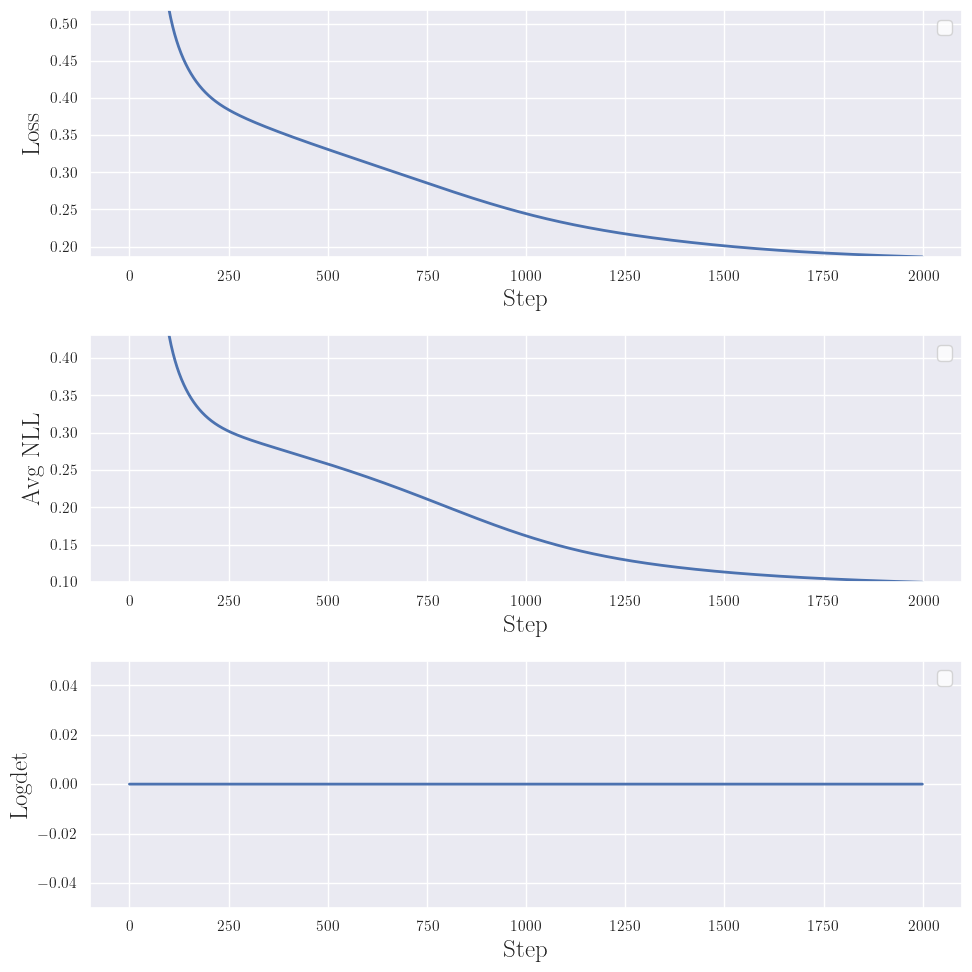

log_likelihood: -19.901155471801758, log_param_prior: -17.293794631958008, log_det: -23400.63671875


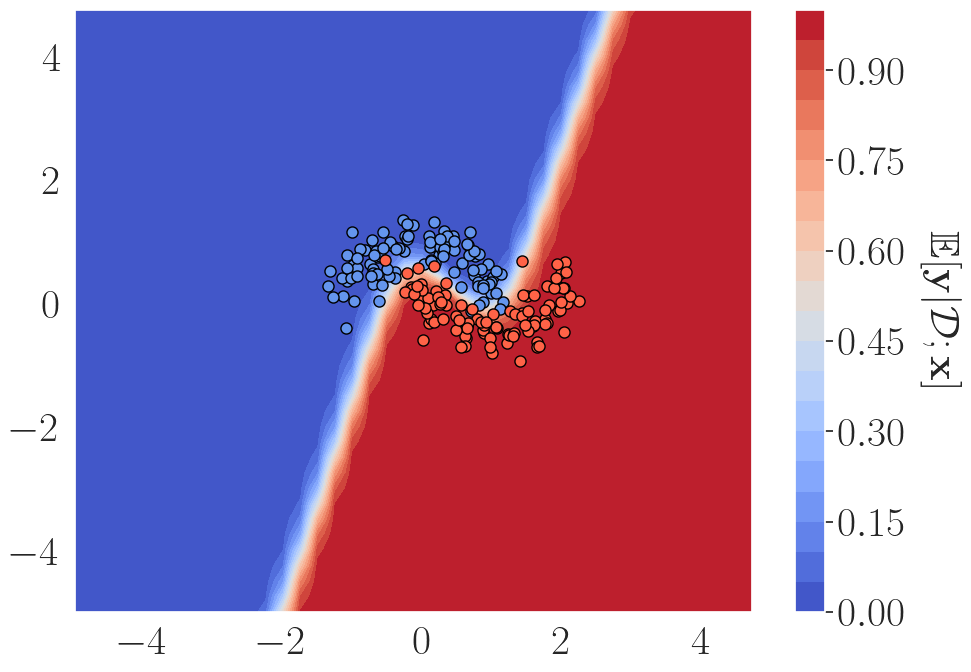

In [27]:
# PSMAP
reparam = lambda x: x
reparam_inv = lambda w: w

widths = [16]
depths = [2]
acts = ['tanh']


optimizer = 'adam'
lr = 1e-3
n_step = int(2e3)
prior_scales = [1]
noise_scale = 0
n_eval = 400
x_lims = [-5, 5]

def x_eval_generator(rng_key):
    X_eval = x_test
    return X_eval

skip_if_done = True
fsmap = False
temps = [1]
method = 'exact'
jitter = 1e-32

pmap_results = []
for width in widths:
    for depth in depths:
        for act in acts:
            for prior_scale in prior_scales:
                for temp in temps:
                    output_dir = f'psmap'
                    # mkdir if needed
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    for seed in range(1):
                        arch = partial(ReparamMLP, reparam=reparam, reparam_inv=reparam_inv, H=width, hidden_layers=depth, act=activations[act])
                        result_path = f'{output_dir}/result_{seed}.pt'
                        if os.path.exists(result_path) and skip_if_done:
                            pmap_results.append(torch.load(result_path))
                            print('Loaded result from ', result_path)
                        else:
                            gt_params = None
                            pmap_results.append(run_two_moons(arch, noise_scale, prior_scale, x_train, y_train, x_test, y_test, gt_params, x_eval_generator, n_step, lr, optimizer, output_dir, seed, fsmap=fsmap, method=method, temp=temp, jitter=jitter))

Number of parameters: 354


  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_541457/1302039264.py:79: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  treedef = jax.tree_structure(target)
/tmp/ipykernel_541457/1302039264.py:81: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, keys)
100%|██████████| 2000/2000 [02:41<00:00, 12.35it/s]


Saved ps parameters at  pathology/params_0.pt


<Figure size 600x400 with 0 Axes>

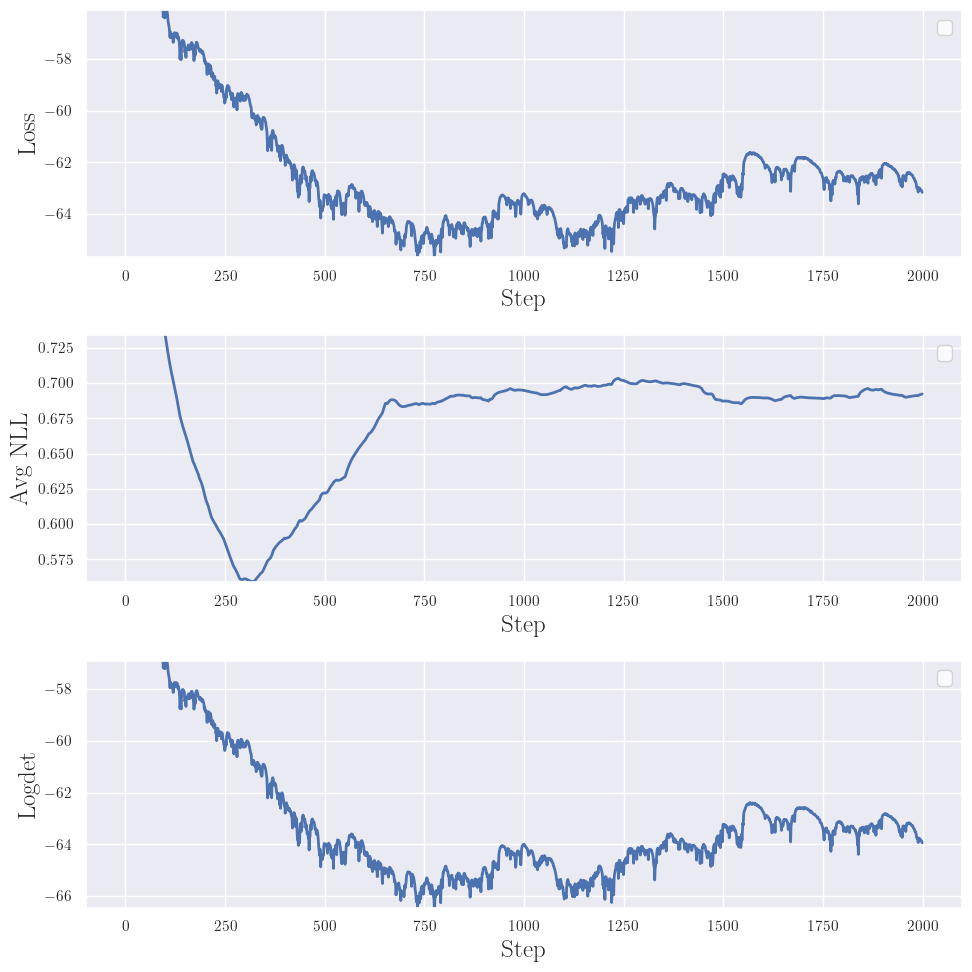

log_likelihood: -138.45608520507812, log_param_prior: -16.56732177734375, log_det: -25588.61328125


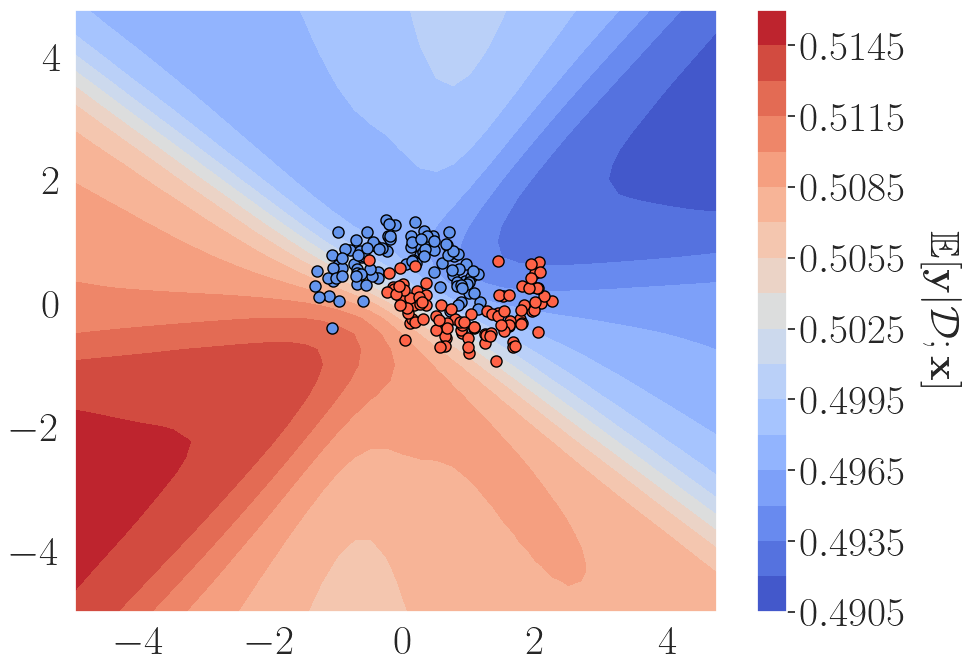

In [28]:
reparam = lambda x: x
reparam_inv = lambda w: w

widths = [16]
depths = [2]
acts = ['tanh']


optimizer = 'adam'
lr = 1e-3
n_step = int(2e3)
prior_scales = [1]
noise_scale = 0
n_eval = 400
x_lims = [-5, 5]

def x_eval_generator(rng_key):
    X_eval = x_test
    return X_eval

skip_if_done = True
fsmap = True
temps = [1]
method = 'exact'
jitter = 1e-32

pmap_results = []
for width in widths:
    for depth in depths:
        for act in acts:
            for prior_scale in prior_scales:
                for temp in temps:
                    output_dir = f'pathology'
                    # mkdir if needed
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    for seed in range(1):
                        arch = partial(ReparamMLP, reparam=reparam, reparam_inv=reparam_inv, H=width, hidden_layers=depth, act=activations[act])
                        result_path = f'{output_dir}/result_{seed}.pt'
                        if os.path.exists(result_path) and skip_if_done:
                            pmap_results.append(torch.load(result_path))
                            print('Loaded result from ', result_path)
                        else:
                            gt_params = None
                            pmap_results.append(run_two_moons(arch, noise_scale, prior_scale, x_train, y_train, x_test, y_test, gt_params, x_eval_generator, n_step, lr, optimizer, output_dir, seed, fsmap=fsmap, method=method, temp=temp, jitter=jitter))

In [71]:
def log_posterior(model, params, x_context, jitter):
    log_likelihood = jnp.sum(jnp.sum(jax.nn.log_softmax(model.apply(params, x_train), axis=1) * y_train_one_hot, axis=1))
    log_param_prior = -0.5 * jnp.sum(jnp.array([jnp.sum(p ** 2) for p in jax.tree_util.tree_leaves(params)])) / (prior_scale ** 2)
    log_det = log_det_K_svd(model, params, x_context, jitter)
    # print(f'log_likelihood: {log_likelihood}, log_param_prior: {log_param_prior}, log_det: {log_det}')
    return log_likelihood, log_param_prior, log_det

rng_key = jax.random.PRNGKey(0)
arch = partial(ReparamMLP, reparam=reparam, reparam_inv=reparam_inv, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)
init_params = model.init(rng_key, x_train)
# split key
rng_key, rng_key_sample = jax.random.split(rng_key)
# gaussian random param
v1 = jax.tree_util.tree_map(lambda x: jax.random.normal(rng_key_sample, x.shape), init_params)
# make v1 unit norm
v1_norm2 = jnp.sum(jnp.array([jnp.sum(p ** 2) for p in jax.tree_util.tree_leaves(v1)]))
v1 = jax.tree_util.tree_map(lambda x: x / jnp.sqrt(v1_norm2), v1)
# plot log posterior on the ray spanned by v1

alpha = jnp.concatenate([jnp.linspace(-1, 0, 51), jnp.array([-0.01, -0.001, -0.0001, 0.0001, 0.001, 0.01]), jnp.linspace(0, 1, 51)])
alpha = alpha[alpha != 0]
# jitter = 1e-32
x_context = x_test
y_train_one_hot = jax.nn.one_hot(y_train.reshape(-1), 2)

log_likelihoods, log_param_priors, log_dets = [], [], []
for a in alpha:
    params = jax.tree_util.tree_map(lambda x: x * a, v1)
    log_likelihood, log_param_prior, log_det = log_posterior(model, params, x_context, jitter)
    log_likelihoods.append(log_likelihood)
    log_param_priors.append(log_param_prior)
    log_dets.append(log_det)

log_likelihoods = jnp.array(log_likelihoods)
log_param_priors = jnp.array(log_param_priors)
log_dets = jnp.array(log_dets)

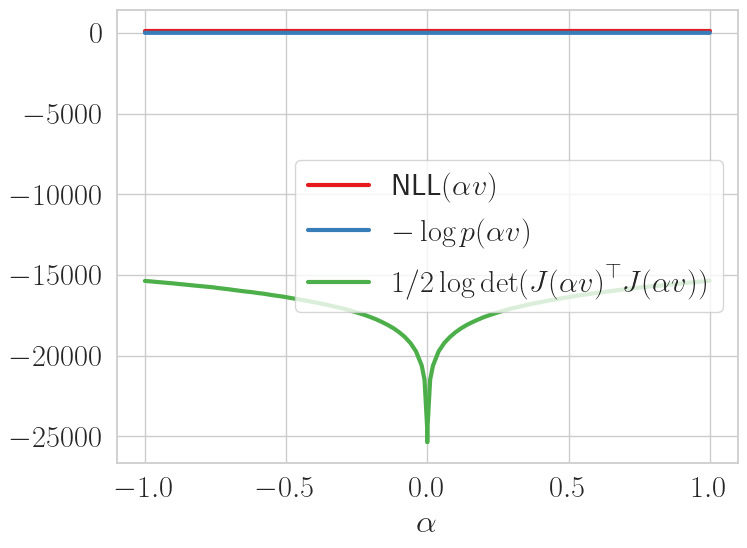

In [73]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="whitegrid", font_scale=2.0, rc={"lines.linewidth": 3.0})
sns.set_palette("Set1")

# plot three quantities, as dots not lines
plt.figure(dpi=100, figsize=(8, 6))
plt.plot(alpha, -log_likelihoods, label=r'NLL$(\alpha v)$')
plt.plot(alpha, -log_param_priors, label=r'$-\log p(\alpha v)$')
plt.plot(alpha[alpha<0], 1/2 * log_dets[alpha<0], label=r'$1/2\log\det(J(\alpha v)^\top J(\alpha v))$')
plt.plot(alpha[alpha>0], 1/2 * log_dets[alpha>0], color='C2')
plt.legend()
plt.xlabel(r'$\alpha$')
plt.tight_layout()
plt.savefig('divergence.pdf')

